In [1]:
trial_number_ml = "010"
random_state_init = 1001

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 18:32:08,507] A new study created in memory with name: no-name-11f5ab36-fd20-4e84-84f8-4e576e1cfdd4


[I 2024-05-01 18:32:48,685] Trial 2 finished with value: 0.729030160810248 and parameters: {'n_estimators': 167, 'max_depth': 53, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.729030160810248.


[I 2024-05-01 18:33:03,891] Trial 3 finished with value: 0.740508335111084 and parameters: {'n_estimators': 226, 'max_depth': 63, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.740508335111084.


[I 2024-05-01 18:34:10,971] Trial 5 finished with value: 0.7153272585052671 and parameters: {'n_estimators': 459, 'max_depth': 70, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 3 with value: 0.740508335111084.


[I 2024-05-01 18:34:30,197] Trial 1 finished with value: 0.7309486077672467 and parameters: {'n_estimators': 906, 'max_depth': 34, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 3 with value: 0.740508335111084.


[I 2024-05-01 18:34:48,173] Trial 6 finished with value: 0.7401918954885767 and parameters: {'n_estimators': 213, 'max_depth': 91, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.740508335111084.


[I 2024-05-01 18:35:02,670] Trial 7 pruned. 


[I 2024-05-01 18:35:30,989] Trial 0 finished with value: 0.7338173894493036 and parameters: {'n_estimators': 868, 'max_depth': 79, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.740508335111084.


[I 2024-05-01 18:35:58,241] Trial 10 pruned. 


[I 2024-05-01 18:36:00,000] Trial 4 finished with value: 0.7370046424689402 and parameters: {'n_estimators': 935, 'max_depth': 70, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.740508335111084.


[I 2024-05-01 18:36:18,861] Trial 12 pruned. 


[I 2024-05-01 18:36:33,064] Trial 13 pruned. 


[I 2024-05-01 18:36:47,675] Trial 14 pruned. 


[I 2024-05-01 18:36:58,579] Trial 15 pruned. 


[I 2024-05-01 18:37:04,827] Trial 16 pruned. 


[I 2024-05-01 18:37:07,441] Trial 8 finished with value: 0.7389149625656497 and parameters: {'n_estimators': 662, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.740508335111084.


[I 2024-05-01 18:37:13,593] Trial 9 finished with value: 0.740194435132417 and parameters: {'n_estimators': 596, 'max_depth': 62, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.740508335111084.


[I 2024-05-01 18:37:28,951] Trial 18 pruned. 


[I 2024-05-01 18:38:01,646] Trial 20 pruned. 


[I 2024-05-01 18:38:05,492] Trial 11 finished with value: 0.7408308698788082 and parameters: {'n_estimators': 674, 'max_depth': 80, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:38:22,848] Trial 17 finished with value: 0.7379610723392152 and parameters: {'n_estimators': 307, 'max_depth': 89, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:38:30,918] Trial 22 pruned. 


[I 2024-05-01 18:38:37,307] Trial 23 pruned. 


[I 2024-05-01 18:39:35,403] Trial 21 finished with value: 0.7389185180670264 and parameters: {'n_estimators': 440, 'max_depth': 43, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:39:55,191] Trial 19 finished with value: 0.7401918954885767 and parameters: {'n_estimators': 750, 'max_depth': 59, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:39:56,826] Trial 24 finished with value: 0.7379580247666067 and parameters: {'n_estimators': 429, 'max_depth': 62, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:40:21,751] Trial 28 pruned. 


[I 2024-05-01 18:40:44,929] Trial 25 finished with value: 0.7385969991568383 and parameters: {'n_estimators': 670, 'max_depth': 62, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:40:45,905] Trial 27 pruned. 


[I 2024-05-01 18:40:49,495] Trial 29 pruned. 


[I 2024-05-01 18:41:08,839] Trial 31 pruned. 


[I 2024-05-01 18:41:12,783] Trial 30 pruned. 


[I 2024-05-01 18:41:29,736] Trial 34 pruned. 


[I 2024-05-01 18:41:38,502] Trial 26 finished with value: 0.738916486351954 and parameters: {'n_estimators': 682, 'max_depth': 59, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:41:49,459] Trial 36 pruned. 


[I 2024-05-01 18:41:50,023] Trial 32 pruned. 


[I 2024-05-01 18:41:56,697] Trial 37 pruned. 


[I 2024-05-01 18:42:02,819] Trial 38 pruned. 


[I 2024-05-01 18:42:04,295] Trial 39 pruned. 


[I 2024-05-01 18:42:10,531] Trial 40 pruned. 


[I 2024-05-01 18:42:28,707] Trial 42 pruned. 


[I 2024-05-01 18:42:31,507] Trial 35 finished with value: 0.7373226058777517 and parameters: {'n_estimators': 370, 'max_depth': 95, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:42:42,885] Trial 43 pruned. 


[I 2024-05-01 18:42:44,435] Trial 33 finished with value: 0.7405118906124606 and parameters: {'n_estimators': 493, 'max_depth': 81, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:42:58,008] Trial 44 pruned. 


[I 2024-05-01 18:43:25,514] Trial 46 pruned. 


[I 2024-05-01 18:43:27,090] Trial 41 finished with value: 0.7385969991568382 and parameters: {'n_estimators': 520, 'max_depth': 67, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 11 with value: 0.7408308698788082.


[I 2024-05-01 18:43:36,843] Trial 47 pruned. 


[I 2024-05-01 18:44:13,189] Trial 49 pruned. 


[I 2024-05-01 18:44:14,920] Trial 48 pruned. 


[I 2024-05-01 18:44:15,900] Trial 45 finished with value: 0.7392354656183017 and parameters: {'n_estimators': 724, 'max_depth': 47, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7408308698788082.


Best trial for RandomForestClassifier:
  Value: 0.7408308698788082
  Params: 
    n_estimators: 674
    max_depth: 80
    min_samples_split: 5
    min_samples_leaf: 2
    max_features: log2

Best hyperparameters for RandomForestClassifier: {'n_estimators': 674, 'max_depth': 80, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2024-05-01 18:44:24,116] A new study created in memory with name: no-name-01080012-9828-463c-a1dc-f56e20c0f6d8


RandomForestClassifier accuracy: 0.7338



[I 2024-05-01 18:44:31,665] Trial 0 finished with value: 0.7032151891018803 and parameters: {'n_estimators': 288, 'max_depth': 4, 'learning_rate': 0.29027061466750537, 'min_child_weight': 6, 'subsample': 0.6775917718488864, 'colsample_bytree': 0.7934800005809246, 'gamma': 2.7128568880459043, 'reg_lambda': 0.8226446053643448, 'reg_alpha': 0.012550477863063538}. Best is trial 0 with value: 0.7032151891018803.


[I 2024-05-01 18:44:37,985] Trial 2 finished with value: 0.7185251780290333 and parameters: {'n_estimators': 557, 'max_depth': 6, 'learning_rate': 0.2180708791402591, 'min_child_weight': 7, 'subsample': 0.6578129626964632, 'colsample_bytree': 0.7939312350364502, 'gamma': 4.976146876615718, 'reg_lambda': 0.3602442732590959, 'reg_alpha': 0.3492296561457223}. Best is trial 2 with value: 0.7185251780290333.


[I 2024-05-01 18:44:41,500] Trial 3 finished with value: 0.7191550097014394 and parameters: {'n_estimators': 473, 'max_depth': 5, 'learning_rate': 0.1144802384843274, 'min_child_weight': 5, 'subsample': 0.5864708013589243, 'colsample_bytree': 0.6252645675819306, 'gamma': 0.45039909095613173, 'reg_lambda': 1.1316502454174577, 'reg_alpha': 1.636469539317205}. Best is trial 3 with value: 0.7191550097014394.


[I 2024-05-01 18:44:42,939] Trial 1 finished with value: 0.7338234845945205 and parameters: {'n_estimators': 449, 'max_depth': 9, 'learning_rate': 0.027895854828497248, 'min_child_weight': 5, 'subsample': 0.6204995905888129, 'colsample_bytree': 0.5473881804475316, 'gamma': 0.7434237543648609, 'reg_lambda': 0.011810249006203172, 'reg_alpha': 3.635188876485907}. Best is trial 1 with value: 0.7338234845945205.


[I 2024-05-01 18:44:47,579] Trial 4 finished with value: 0.7258505267221325 and parameters: {'n_estimators': 355, 'max_depth': 10, 'learning_rate': 0.045495399045822636, 'min_child_weight': 1, 'subsample': 0.5408697365746162, 'colsample_bytree': 0.9215964905658647, 'gamma': 1.9489801750929803, 'reg_lambda': 1.9848537044606127, 'reg_alpha': 0.7668029229808502}. Best is trial 1 with value: 0.7338234845945205.


[I 2024-05-01 18:44:48,403] Trial 7 pruned. 


[I 2024-05-01 18:44:48,572] Trial 6 pruned. 


[I 2024-05-01 18:44:48,633] Trial 8 pruned. 


[I 2024-05-01 18:44:50,240] Trial 10 pruned. 


[I 2024-05-01 18:44:51,065] Trial 9 pruned. 


[I 2024-05-01 18:44:52,442] Trial 12 pruned. 


[I 2024-05-01 18:44:55,414] Trial 13 pruned. 


[I 2024-05-01 18:44:56,420] Trial 5 finished with value: 0.7264915328274363 and parameters: {'n_estimators': 926, 'max_depth': 8, 'learning_rate': 0.07420483685077267, 'min_child_weight': 3, 'subsample': 0.921442360146747, 'colsample_bytree': 0.5728702951631743, 'gamma': 3.109904695508636, 'reg_lambda': 0.46309704347442715, 'reg_alpha': 3.9921011625174043}. Best is trial 1 with value: 0.7338234845945205.


[I 2024-05-01 18:44:56,919] Trial 11 finished with value: 0.7284003291378417 and parameters: {'n_estimators': 244, 'max_depth': 4, 'learning_rate': 0.12449521621236431, 'min_child_weight': 2, 'subsample': 0.9518418051779622, 'colsample_bytree': 0.8044025475764119, 'gamma': 0.34175510021837996, 'reg_lambda': 2.0283703045107706, 'reg_alpha': 0.02543779869400141}. Best is trial 1 with value: 0.7338234845945205.


[I 2024-05-01 18:44:58,426] Trial 17 pruned. 


[I 2024-05-01 18:44:58,896] Trial 14 finished with value: 0.7303091254482471 and parameters: {'n_estimators': 103, 'max_depth': 8, 'learning_rate': 0.029853831831544584, 'min_child_weight': 1, 'subsample': 0.5013937477407594, 'colsample_bytree': 0.9849238838655539, 'gamma': 1.4924303695586083, 'reg_lambda': 0.07982948830849412, 'reg_alpha': 0.29014327085824126}. Best is trial 1 with value: 0.7338234845945205.


[I 2024-05-01 18:45:00,204] Trial 18 pruned. 


[I 2024-05-01 18:45:00,232] Trial 19 pruned. 


[I 2024-05-01 18:45:01,855] Trial 21 pruned. 


[I 2024-05-01 18:45:02,183] Trial 20 pruned. 


[I 2024-05-01 18:45:05,423] Trial 23 pruned. 


[I 2024-05-01 18:45:06,567] Trial 24 pruned. 


[I 2024-05-01 18:45:07,062] Trial 15 finished with value: 0.7408318857363443 and parameters: {'n_estimators': 169, 'max_depth': 10, 'learning_rate': 0.018286585686860785, 'min_child_weight': 1, 'subsample': 0.518451769288031, 'colsample_bytree': 0.9835974345983102, 'gamma': 1.545191892986645, 'reg_lambda': 0.06770274924747986, 'reg_alpha': 0.30833647212963344}. Best is trial 15 with value: 0.7408318857363443.


[I 2024-05-01 18:45:16,245] Trial 26 finished with value: 0.7354127937098102 and parameters: {'n_estimators': 133, 'max_depth': 9, 'learning_rate': 0.03853391001824314, 'min_child_weight': 1, 'subsample': 0.5632689421399575, 'colsample_bytree': 0.8601867030715458, 'gamma': 1.6688174732297143, 'reg_lambda': 0.15283191913880212, 'reg_alpha': 0.7639290402086834}. Best is trial 15 with value: 0.7408318857363443.


[I 2024-05-01 18:45:17,182] Trial 25 finished with value: 0.7350933065146943 and parameters: {'n_estimators': 219, 'max_depth': 7, 'learning_rate': 0.04687475319223258, 'min_child_weight': 1, 'subsample': 0.7604526706399658, 'colsample_bytree': 0.844170911172502, 'gamma': 0.004976071313070429, 'reg_lambda': 0.18094079838133983, 'reg_alpha': 0.02634012523735382}. Best is trial 15 with value: 0.7408318857363443.


[I 2024-05-01 18:45:18,334] Trial 27 pruned. 


[I 2024-05-01 18:45:19,094] Trial 22 finished with value: 0.7338173894493036 and parameters: {'n_estimators': 443, 'max_depth': 9, 'learning_rate': 0.030716028045427963, 'min_child_weight': 2, 'subsample': 0.5971842821767039, 'colsample_bytree': 0.709278334505932, 'gamma': 3.6193279427434564, 'reg_lambda': 0.03898384351871082, 'reg_alpha': 0.16712645043021132}. Best is trial 15 with value: 0.7408318857363443.


[I 2024-05-01 18:45:19,344] Trial 28 pruned. 


[I 2024-05-01 18:45:19,865] Trial 29 pruned. 


[I 2024-05-01 18:45:21,085] Trial 31 pruned. 


[I 2024-05-01 18:45:21,114] Trial 32 pruned. 


[I 2024-05-01 18:45:21,619] Trial 30 pruned. 


[I 2024-05-01 18:45:22,714] Trial 33 pruned. 


[I 2024-05-01 18:45:24,576] Trial 34 pruned. 


[I 2024-05-01 18:45:25,674] Trial 36 pruned. 


[I 2024-05-01 18:45:27,254] Trial 16 finished with value: 0.7376466644317802 and parameters: {'n_estimators': 910, 'max_depth': 8, 'learning_rate': 0.011144770799297484, 'min_child_weight': 1, 'subsample': 0.8589476004969259, 'colsample_bytree': 0.5746667911698841, 'gamma': 3.5584254457896267, 'reg_lambda': 0.08357333661354283, 'reg_alpha': 0.13280255265457788}. Best is trial 15 with value: 0.7408318857363443.


[I 2024-05-01 18:45:28,156] Trial 37 pruned. 


[I 2024-05-01 18:45:28,389] Trial 38 pruned. 


[I 2024-05-01 18:45:30,873] Trial 39 pruned. 


[I 2024-05-01 18:45:32,935] Trial 41 pruned. 


[I 2024-05-01 18:45:34,453] Trial 42 pruned. 


[I 2024-05-01 18:45:34,691] Trial 43 pruned. 


[I 2024-05-01 18:45:34,936] Trial 40 pruned. 


[I 2024-05-01 18:45:39,524] Trial 46 pruned. 


[I 2024-05-01 18:45:39,741] Trial 35 finished with value: 0.7398764717236055 and parameters: {'n_estimators': 326, 'max_depth': 9, 'learning_rate': 0.032356181829237836, 'min_child_weight': 3, 'subsample': 0.6671902636552044, 'colsample_bytree': 0.9486108800977157, 'gamma': 0.7961630533798808, 'reg_lambda': 0.10037608002316993, 'reg_alpha': 2.940972812360756}. Best is trial 15 with value: 0.7408318857363443.


[I 2024-05-01 18:45:39,845] Trial 44 pruned. 


[I 2024-05-01 18:45:41,472] Trial 45 pruned. 


[I 2024-05-01 18:45:42,007] Trial 49 pruned. 


[I 2024-05-01 18:45:42,813] Trial 48 pruned. 


[I 2024-05-01 18:45:43,808] Trial 47 pruned. 


Best trial for XGBClassifier:
  Value: 0.7408318857363443
  Params: 
    n_estimators: 169
    max_depth: 10
    learning_rate: 0.018286585686860785
    min_child_weight: 1
    subsample: 0.518451769288031
    colsample_bytree: 0.9835974345983102
    gamma: 1.545191892986645
    reg_lambda: 0.06770274924747986
    reg_alpha: 0.30833647212963344

Best hyperparameters for XGBClassifier: {'n_estimators': 169, 'max_depth': 10, 'learning_rate': 0.018286585686860785, 'min_child_weight': 1, 'subsample': 0.518451769288031, 'colsample_bytree': 0.9835974345983102, 'gamma': 1.545191892986645, 'reg_lambda': 0.06770274924747986, 'reg_alpha': 0.30833647212963344}


[I 2024-05-01 18:46:24,753] A new study created in memory with name: no-name-31d47f86-d672-42a1-ad39-6f3d11289eb3


XGBClassifier accuracy: 0.7287



[I 2024-05-01 18:46:25,380] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.056979486159386576, 'n_estimators': 242, 'min_child_weight': 0.04342796237354226, 'min_child_samples': 1280, 'subsample': 0.9765280922443171, 'colsample_bytree': 0.8134761813645909, 'reg_alpha': 0.003396744379697157, 'reg_lambda': 2.84543966408902e-05}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 18:46:25,630] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'max_depth': -1, 'learning_rate': 0.1907642451887476, 'n_estimators': 686, 'min_child_weight': 0.04444547249180261, 'min_child_samples': 1927, 'subsample': 0.9494075939438319, 'colsample_bytree': 0.8760783799477591, 'reg_alpha': 9.637424603886755e-08, 'reg_lambda': 0.0512809796022799}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 18:46:26,208] Trial 4 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 96, 'max_depth': 10, 'learning_rate': 0.3555388178277828, 'n_estimators': 823, 'min_child_weight': 0.0018016265460612927, 'min_child_samples': 1275, 'subsample': 0.8899782149124188, 'colsample_bytree': 0.8597805726410102, 'reg_alpha': 9.215640961951065e-05, 'reg_lambda': 0.000253579891190591}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 18:46:26,702] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 85, 'max_depth': 11, 'learning_rate': 0.28300321260227534, 'n_estimators': 222, 'min_child_weight': 0.07355476954084285, 'min_child_samples': 1400, 'subsample': 0.81902355070974, 'colsample_bytree': 0.8988682985910088, 'reg_alpha': 5.966679726479083e-09, 'reg_lambda': 0.00011220119698444451}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 18:46:29,656] Trial 7 finished with value: 0.6646374912382287 and parameters: {'boosting_type': 'goss', 'num_leaves': 62, 'max_depth': 6, 'learning_rate': 0.013435543646113147, 'n_estimators': 647, 'min_child_weight': 0.003092705832532565, 'min_child_samples': 414, 'subsample': 0.8096390972841253, 'colsample_bytree': 0.8967219023531985, 'reg_alpha': 0.0012195329675637062, 'reg_lambda': 2.919415827422822e-09}. Best is trial 7 with value: 0.6646374912382287.


[I 2024-05-01 18:46:30,192] Trial 8 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 66, 'max_depth': 15, 'learning_rate': 0.49637772761803967, 'n_estimators': 259, 'min_child_weight': 0.03385001442229396, 'min_child_samples': 1552, 'subsample': 0.8829410880274811, 'colsample_bytree': 0.9324971838942482, 'reg_alpha': 3.24899248440791e-10, 'reg_lambda': 0.18030234599320377}. Best is trial 7 with value: 0.6646374912382287.


[I 2024-05-01 18:46:30,813] Trial 9 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 85, 'max_depth': 6, 'learning_rate': 0.25379294549821346, 'n_estimators': 410, 'min_child_weight': 0.0012545443197095527, 'min_child_samples': 1568, 'subsample': 0.9687102710239707, 'colsample_bytree': 0.9520334328213694, 'reg_alpha': 2.093174053754626e-09, 'reg_lambda': 1.232005547440465e-07}. Best is trial 7 with value: 0.6646374912382287.


[I 2024-05-01 18:46:31,786] Trial 2 finished with value: 0.7057731183778786 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 15, 'learning_rate': 0.15321057980439307, 'n_estimators': 473, 'min_child_weight': 0.003331620114904438, 'min_child_samples': 217, 'subsample': 0.8983718881468016, 'colsample_bytree': 0.8804364219016325, 'reg_alpha': 5.363149898511273e-05, 'reg_lambda': 0.15652260659635367}. Best is trial 2 with value: 0.7057731183778786.


[I 2024-05-01 18:46:32,353] Trial 11 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 91, 'max_depth': -1, 'learning_rate': 0.4492769205087989, 'n_estimators': 283, 'min_child_weight': 0.013654829402113506, 'min_child_samples': 1792, 'subsample': 0.9145542895935231, 'colsample_bytree': 0.908867731313605, 'reg_alpha': 3.83942532736625e-07, 'reg_lambda': 0.0001430153499236083}. Best is trial 2 with value: 0.7057731183778786.


[I 2024-05-01 18:46:32,695] Trial 10 finished with value: 0.5600879732626296 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': -1, 'learning_rate': 0.29904418662240034, 'n_estimators': 560, 'min_child_weight': 0.00554538249862972, 'min_child_samples': 1180, 'subsample': 0.8084044192994381, 'colsample_bytree': 0.8000566582817573, 'reg_alpha': 3.072991024963603e-06, 'reg_lambda': 0.0005528453496818837}. Best is trial 2 with value: 0.7057731183778786.


[I 2024-05-01 18:46:33,253] Trial 12 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'max_depth': 0, 'learning_rate': 0.45335890758338054, 'n_estimators': 936, 'min_child_weight': 0.0026044333814940323, 'min_child_samples': 1506, 'subsample': 0.8853102287051707, 'colsample_bytree': 0.9711673015420347, 'reg_alpha': 4.440058879234346e-07, 'reg_lambda': 6.287567557904198e-09}. Best is trial 2 with value: 0.7057731183778786.


[I 2024-05-01 18:46:40,891] Trial 14 finished with value: 0.7057629598025172 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 5, 'learning_rate': 0.016593616405156386, 'n_estimators': 576, 'min_child_weight': 0.00527174695495008, 'min_child_samples': 202, 'subsample': 0.8448566011466551, 'colsample_bytree': 0.8498850725767328, 'reg_alpha': 0.41236634960181323, 'reg_lambda': 1.2947996001107836e-10}. Best is trial 2 with value: 0.7057731183778786.


[I 2024-05-01 18:46:42,930] Trial 5 finished with value: 0.6850369264214387 and parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'max_depth': 7, 'learning_rate': 0.18825122360334673, 'n_estimators': 580, 'min_child_weight': 0.035607399763146724, 'min_child_samples': 525, 'subsample': 0.8820641335823026, 'colsample_bytree': 0.870144791531656, 'reg_alpha': 0.002984764993976227, 'reg_lambda': 4.653375244042537e-06}. Best is trial 2 with value: 0.7057731183778786.


[I 2024-05-01 18:46:46,172] Trial 15 finished with value: 0.7172360548156727 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 3, 'learning_rate': 0.12193963277872137, 'n_estimators': 463, 'min_child_weight': 0.00884020030352664, 'min_child_samples': 63, 'subsample': 0.8520140247394797, 'colsample_bytree': 0.8474229871574617, 'reg_alpha': 0.9350433995635351, 'reg_lambda': 3.7882839819404807e-07}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:46:47,190] Trial 17 finished with value: 0.634996292119993 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 3, 'learning_rate': 0.13857106423922036, 'n_estimators': 125, 'min_child_weight': 0.011508397588543695, 'min_child_samples': 820, 'subsample': 0.855516158187671, 'colsample_bytree': 0.8310684237541802, 'reg_alpha': 0.599138316485574, 'reg_lambda': 9.21257915287569e-07}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:46:47,619] Trial 16 finished with value: 0.7076814067595161 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 4, 'learning_rate': 0.10830419139369636, 'n_estimators': 429, 'min_child_weight': 0.009474823655257621, 'min_child_samples': 219, 'subsample': 0.8563807411881255, 'colsample_bytree': 0.8341701974099504, 'reg_alpha': 0.6830363248150721, 'reg_lambda': 1.840230194774821e-10}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:46:51,905] Trial 13 finished with value: 0.7159687725393391 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 15, 'learning_rate': 0.13871902543109618, 'n_estimators': 935, 'min_child_weight': 0.009925812438050078, 'min_child_samples': 85, 'subsample': 0.856891237434575, 'colsample_bytree': 0.9929637671452655, 'reg_alpha': 0.5839405511626231, 'reg_lambda': 0.9250411107656911}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:46:52,817] Trial 19 finished with value: 0.7165960645679049 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 3, 'learning_rate': 0.09039469026012467, 'n_estimators': 388, 'min_child_weight': 0.016365922260784885, 'min_child_samples': 54, 'subsample': 0.8474522190844245, 'colsample_bytree': 0.8350842140739475, 'reg_alpha': 0.05553460184988996, 'reg_lambda': 2.7197940424460074e-10}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:46:53,701] Trial 0 finished with value: 0.7121516878472962 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 12, 'learning_rate': 0.11225956758520483, 'n_estimators': 520, 'min_child_weight': 0.026074364067378095, 'min_child_samples': 22, 'subsample': 0.8929635122733571, 'colsample_bytree': 0.8339664918210107, 'reg_alpha': 8.277332582830424e-08, 'reg_lambda': 0.05389798468876018}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:46:54,903] Trial 21 finished with value: 0.6372266073405866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 2, 'learning_rate': 0.049539898023402806, 'n_estimators': 386, 'min_child_weight': 0.01851929084523668, 'min_child_samples': 800, 'subsample': 0.8318025702088299, 'colsample_bytree': 0.8310424386204536, 'reg_alpha': 0.033276785666500025, 'reg_lambda': 3.268090692395939e-08}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:46:56,642] Trial 20 finished with value: 0.6349962921199932 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.08860093743943989, 'n_estimators': 997, 'min_child_weight': 0.01896784060850317, 'min_child_samples': 778, 'subsample': 0.9291812977665944, 'colsample_bytree': 0.9941596368324479, 'reg_alpha': 0.03230507129299026, 'reg_lambda': 0.013450490633835294}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:01,799] Trial 23 finished with value: 0.6875836812645395 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 2, 'learning_rate': 0.20086081410822737, 'n_estimators': 332, 'min_child_weight': 0.006369083946283861, 'min_child_samples': 517, 'subsample': 0.8345233567853936, 'colsample_bytree': 0.9229215009958212, 'reg_alpha': 0.013073228057964065, 'reg_lambda': 3.7270920751172054e-07}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:02,539] Trial 22 finished with value: 0.6314880281189366 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 2, 'learning_rate': 0.07042244147463836, 'n_estimators': 401, 'min_child_weight': 0.01895027503774127, 'min_child_samples': 780, 'subsample': 0.837101823919235, 'colsample_bytree': 0.8500163336479428, 'reg_alpha': 0.060688387229146226, 'reg_lambda': 6.065269508849097e-08}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:06,723] Trial 24 finished with value: 0.7121445768445434 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 2, 'learning_rate': 0.17005628418051405, 'n_estimators': 750, 'min_child_weight': 0.006905627220898579, 'min_child_samples': 20, 'subsample': 0.8592134055989646, 'colsample_bytree': 0.9260667413168613, 'reg_alpha': 0.05356822357879344, 'reg_lambda': 0.003197771735756695}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:08,127] Trial 25 finished with value: 0.7086342811284145 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 1, 'learning_rate': 0.0741691869210005, 'n_estimators': 758, 'min_child_weight': 0.0082583687352476, 'min_child_samples': 39, 'subsample': 0.8664794222562158, 'colsample_bytree': 0.9741539065565269, 'reg_alpha': 0.1988331046083106, 'reg_lambda': 0.002393269254761298}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:11,376] Trial 18 finished with value: 0.7064085372667337 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 14, 'learning_rate': 0.12140183226801055, 'n_estimators': 423, 'min_child_weight': 0.007773590204613153, 'min_child_samples': 32, 'subsample': 0.9313540865526979, 'colsample_bytree': 0.83728414653343, 'reg_alpha': 9.105286014279775e-05, 'reg_lambda': 0.009357373359645071}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:14,850] Trial 27 finished with value: 0.6942842775729131 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 8, 'learning_rate': 0.22813634602745203, 'n_estimators': 824, 'min_child_weight': 0.009172633004122282, 'min_child_samples': 378, 'subsample': 0.8648172307434319, 'colsample_bytree': 0.9983074276765604, 'reg_alpha': 0.0004763025771832261, 'reg_lambda': 2.545567979715085e-06}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:16,455] Trial 28 finished with value: 0.7000228567945632 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 8, 'learning_rate': 0.24289801168848985, 'n_estimators': 884, 'min_child_weight': 0.011935475156125124, 'min_child_samples': 380, 'subsample': 0.91556659850718, 'colsample_bytree': 0.8047538669349935, 'reg_alpha': 0.00035694920158294295, 'reg_lambda': 1.2752333228749992e-09}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:17,178] Trial 30 finished with value: 0.6993859141194039 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 4, 'learning_rate': 0.14797502686089253, 'n_estimators': 171, 'min_child_weight': 0.004357219870584729, 'min_child_samples': 293, 'subsample': 0.8260312336794269, 'colsample_bytree': 0.8034947219239711, 'reg_alpha': 0.008218044414263746, 'reg_lambda': 7.970115147272161e-10}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:18,710] Trial 32 pruned. 


[I 2024-05-01 18:47:20,216] Trial 29 finished with value: 0.6968366196324627 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 8, 'learning_rate': 0.22202093006868978, 'n_estimators': 849, 'min_child_weight': 0.004112234766290137, 'min_child_samples': 355, 'subsample': 0.871268747440111, 'colsample_bytree': 0.8059441771939339, 'reg_alpha': 0.000560643932634227, 'reg_lambda': 1.033765293929256e-09}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:22,993] Trial 33 finished with value: 0.7156477615579192 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 4, 'learning_rate': 0.03164076895231409, 'n_estimators': 316, 'min_child_weight': 0.015057049484128927, 'min_child_samples': 141, 'subsample': 0.8740851335183605, 'colsample_bytree': 0.8863351285504952, 'reg_alpha': 0.7670293778345559, 'reg_lambda': 1.3902506612715747e-05}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:24,046] Trial 31 finished with value: 0.7070485275145014 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 4, 'learning_rate': 0.13615747798418087, 'n_estimators': 644, 'min_child_weight': 0.004371574322341415, 'min_child_samples': 215, 'subsample': 0.8241335874951246, 'colsample_bytree': 0.8191961179450556, 'reg_alpha': 0.007027899142296769, 'reg_lambda': 0.6769956915116856}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:26,947] Trial 35 finished with value: 0.7146923475451803 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 4, 'learning_rate': 0.03685486472897186, 'n_estimators': 316, 'min_child_weight': 0.01532449666559669, 'min_child_samples': 177, 'subsample': 0.8478794199917342, 'colsample_bytree': 0.877233644605433, 'reg_alpha': 0.9750289136594166, 'reg_lambda': 2.0117586950593083e-05}. Best is trial 15 with value: 0.7172360548156727.


[I 2024-05-01 18:47:29,399] Trial 36 finished with value: 0.7185145115249038 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 5, 'learning_rate': 0.02796346935299237, 'n_estimators': 342, 'min_child_weight': 0.014564327838954033, 'min_child_samples': 145, 'subsample': 0.8470662977527346, 'colsample_bytree': 0.8839927398436724, 'reg_alpha': 0.20697253429155327, 'reg_lambda': 2.689365695870616e-05}. Best is trial 36 with value: 0.7185145115249038.


[I 2024-05-01 18:47:29,754] Trial 37 pruned. 


[I 2024-05-01 18:47:30,292] Trial 39 pruned. 


[I 2024-05-01 18:47:32,586] Trial 26 finished with value: 0.7038572110647203 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 8, 'learning_rate': 0.1565711937729512, 'n_estimators': 772, 'min_child_weight': 0.00844571695627329, 'min_child_samples': 21, 'subsample': 0.865306051375977, 'colsample_bytree': 0.9970293244989913, 'reg_alpha': 0.09849511076071055, 'reg_lambda': 0.0025998199718352977}. Best is trial 36 with value: 0.7185145115249038.


[I 2024-05-01 18:47:32,824] Trial 40 pruned. 


[I 2024-05-01 18:47:33,691] Trial 42 pruned. 


[I 2024-05-01 18:47:35,194] Trial 41 pruned. 


[I 2024-05-01 18:47:35,951] Trial 43 finished with value: 0.7086337731996465 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 3, 'learning_rate': 0.3499703258502267, 'n_estimators': 190, 'min_child_weight': 0.04754867874622337, 'min_child_samples': 297, 'subsample': 0.8938467321866442, 'colsample_bytree': 0.9429967862809615, 'reg_alpha': 0.0019756387517661186, 'reg_lambda': 6.046479879378835e-06}. Best is trial 36 with value: 0.7185145115249038.


[I 2024-05-01 18:47:37,015] Trial 34 finished with value: 0.7146989506191652 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 12, 'learning_rate': 0.10495159571369808, 'n_estimators': 667, 'min_child_weight': 0.015048106300262038, 'min_child_samples': 139, 'subsample': 0.8439635846096379, 'colsample_bytree': 0.8784631439814744, 'reg_alpha': 3.7737809620072645e-08, 'reg_lambda': 0.04079054448263314}. Best is trial 36 with value: 0.7185145115249038.


[I 2024-05-01 18:47:37,809] Trial 44 finished with value: 0.7175631609423094 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.039155883110164345, 'n_estimators': 212, 'min_child_weight': 0.015966894619301057, 'min_child_samples': 123, 'subsample': 0.8533417120717138, 'colsample_bytree': 0.8872575906145955, 'reg_alpha': 0.2850607988520524, 'reg_lambda': 2.750900198553577e-06}. Best is trial 36 with value: 0.7185145115249038.


[I 2024-05-01 18:47:38,780] Trial 47 pruned. 


[I 2024-05-01 18:47:39,439] Trial 45 finished with value: 0.7169241865520779 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.03539677625854826, 'n_estimators': 322, 'min_child_weight': 0.014375457550050515, 'min_child_samples': 120, 'subsample': 0.841165695841795, 'colsample_bytree': 0.9058934170447238, 'reg_alpha': 0.34598470651258195, 'reg_lambda': 0.0004911671930022654}. Best is trial 36 with value: 0.7185145115249038.


[I 2024-05-01 18:47:39,882] Trial 49 pruned. 


[I 2024-05-01 18:47:40,456] Trial 46 finished with value: 0.7153297981491076 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.038392564584944756, 'n_estimators': 299, 'min_child_weight': 0.021342418847728188, 'min_child_samples': 119, 'subsample': 0.8785858099942087, 'colsample_bytree': 0.9086890752947695, 'reg_alpha': 0.32100462741812097, 'reg_lambda': 0.0006069400276030961}. Best is trial 36 with value: 0.7185145115249038.


[I 2024-05-01 18:47:41,915] Trial 48 finished with value: 0.7048090695760826 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 7, 'learning_rate': 0.18669229461910722, 'n_estimators': 229, 'min_child_weight': 0.022589653769658793, 'min_child_samples': 292, 'subsample': 0.8356289928750101, 'colsample_bytree': 0.8935416967077605, 'reg_alpha': 0.00528767853758907, 'reg_lambda': 1.6761595520601198e-06}. Best is trial 36 with value: 0.7185145115249038.


[I 2024-05-01 18:47:53,312] Trial 38 finished with value: 0.7271299992888997 and parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'max_depth': 6, 'learning_rate': 0.09765932930312748, 'n_estimators': 514, 'min_child_weight': 0.02146420820057153, 'min_child_samples': 111, 'subsample': 0.9958995209581523, 'colsample_bytree': 0.8494635640075893, 'reg_alpha': 0.1188984164855593, 'reg_lambda': 3.8442845011758924e-07}. Best is trial 38 with value: 0.7271299992888997.


Best trial for LGBMClassifier:
  Value: 0.7271299992888997
  Params: 
    boosting_type: dart
    num_leaves: 37
    max_depth: 6
    learning_rate: 0.09765932930312748
    n_estimators: 514
    min_child_weight: 0.02146420820057153
    min_child_samples: 111
    subsample: 0.9958995209581523
    colsample_bytree: 0.8494635640075893
    reg_alpha: 0.1188984164855593
    reg_lambda: 3.8442845011758924e-07

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 37, 'max_depth': 6, 'learning_rate': 0.09765932930312748, 'n_estimators': 514, 'min_child_weight': 0.02146420820057153, 'min_child_samples': 111, 'subsample': 0.9958995209581523, 'colsample_bytree': 0.8494635640075893, 'reg_alpha': 0.1188984164855593, 'reg_lambda': 3.8442845011758924e-07}


LGBMClassifier accuracy: 0.7261
LGBMClassifier accuracy: 0.7261



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_010/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

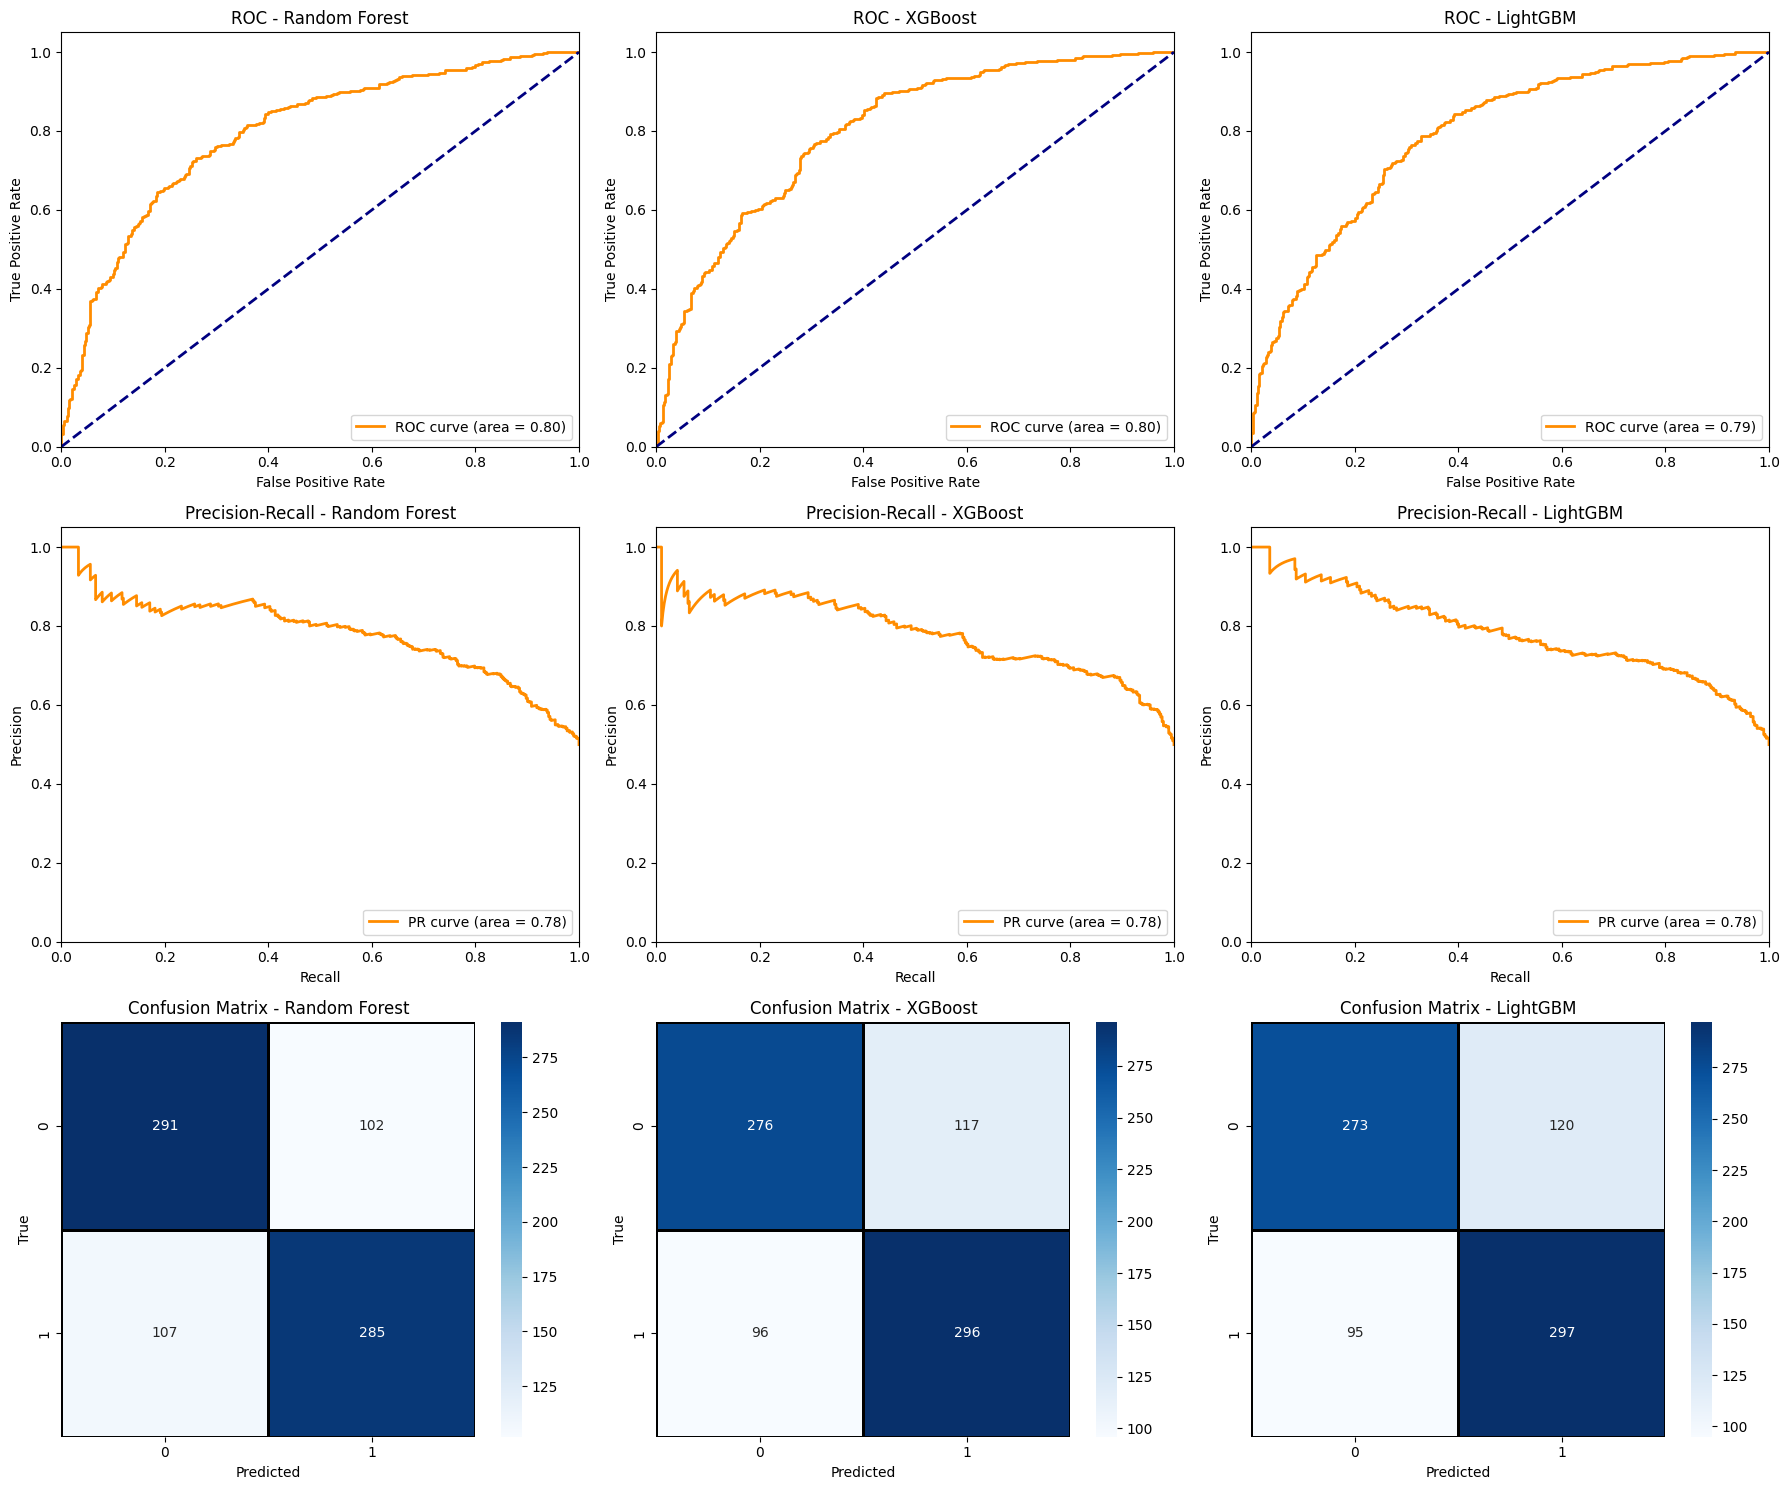

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.7337579617834394, 'Precision': 0.7364341085271318, 'Recall': 0.7270408163265306, 'F1 Score': 0.7317073170731707, 'ROC AUC': 0.7952887261774939}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7286624203821656, 'Precision': 0.7167070217917676, 'Recall': 0.7551020408163265, 'F1 Score': 0.7354037267080745, 'ROC AUC': 0.8013709300514098}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7261146496815286, 'Precision': 0.7122302158273381, 'Recall': 0.7576530612244898, 'F1 Score': 0.7342398022249691, 'ROC AUC': 0.7922378875214209}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7261146496815286,
 'Precision': 0.7122302158273381,
 'Recall': 0.7576530612244898,
 'F1 Score': 0.7342398022249691,
 'ROC AUC': 0.7922378875214209}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.7338


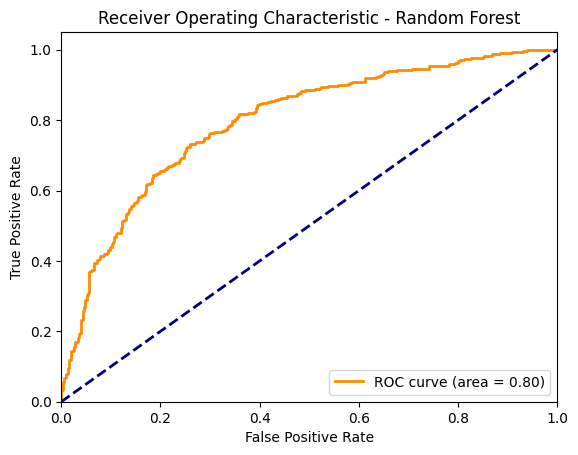

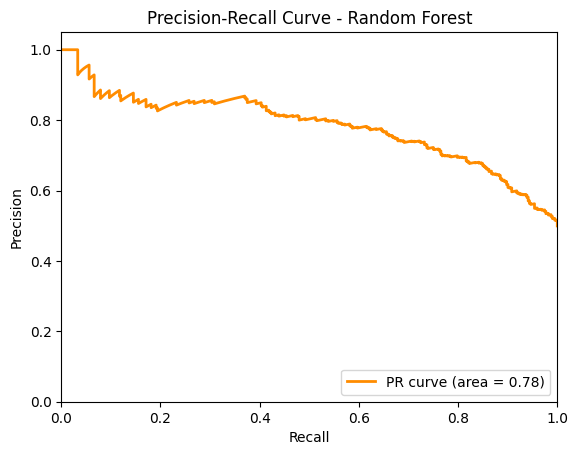

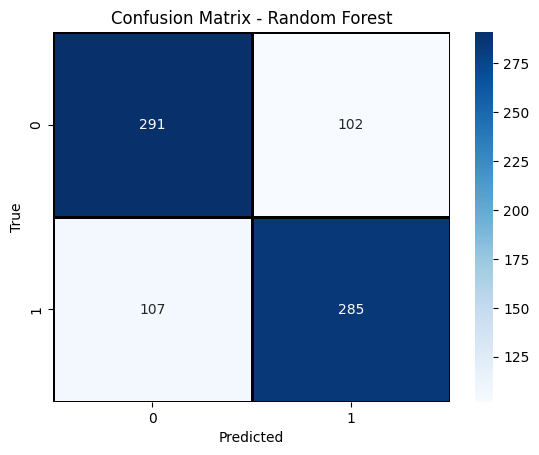

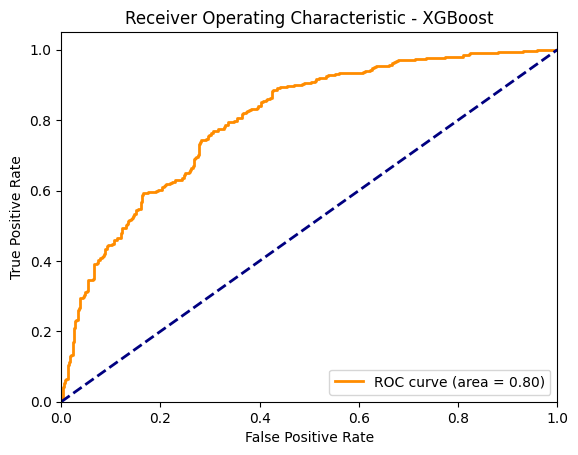

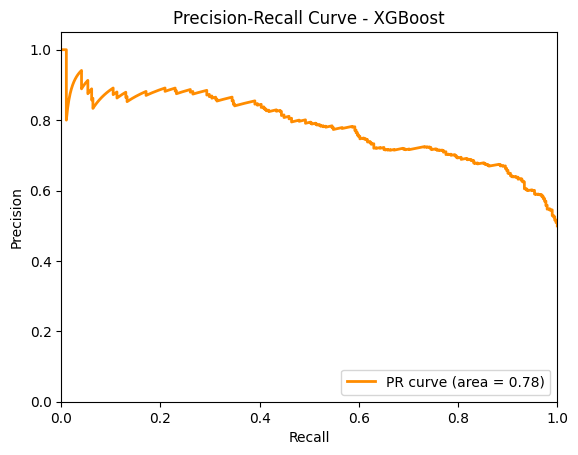

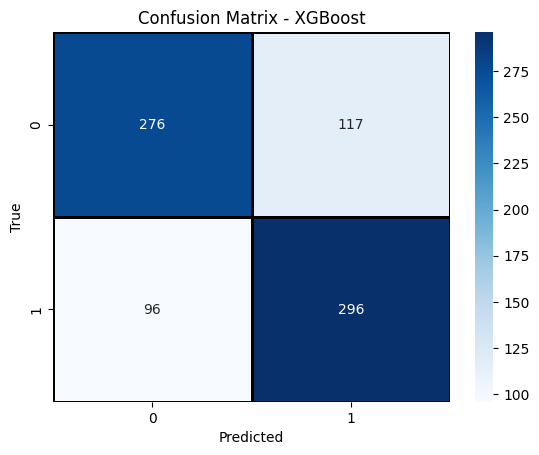

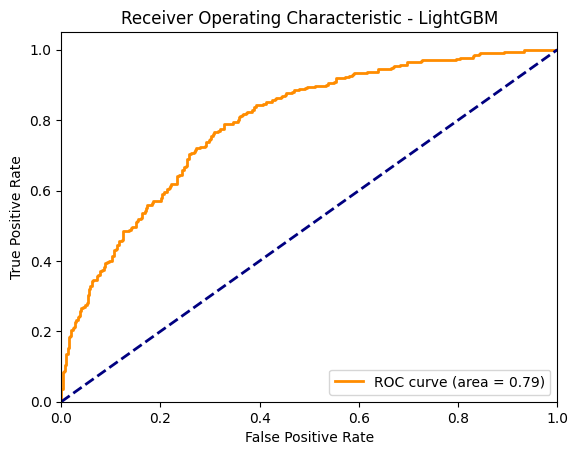

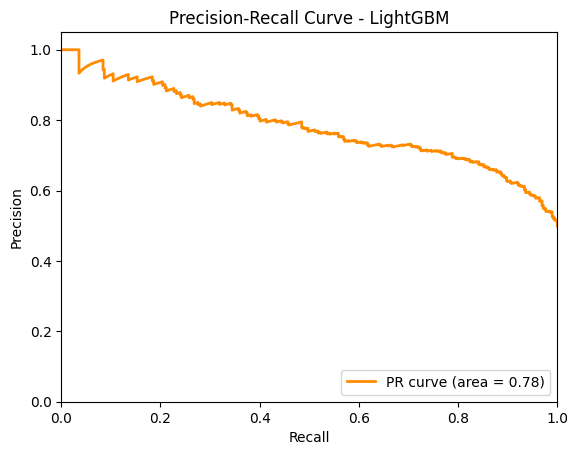

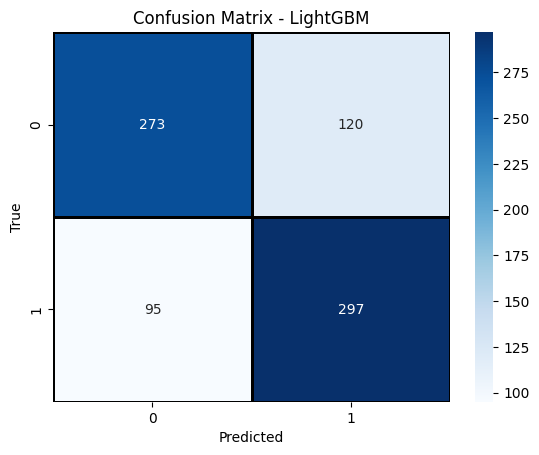

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

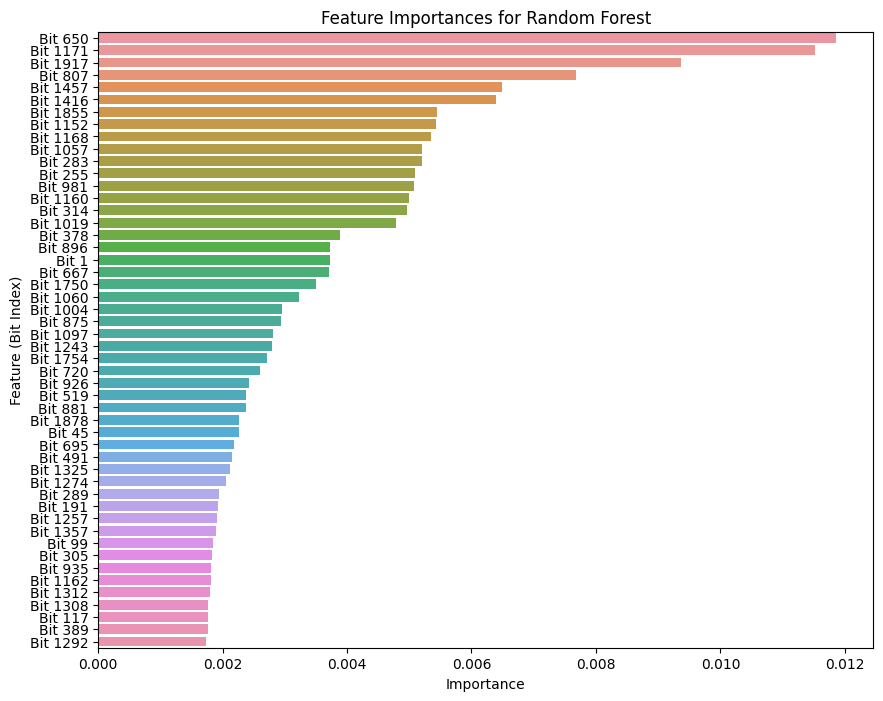

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
